# Accretion disc

In this tutorial we set up a protoplanetary disc around a star represented by a sink particle, and we add a planet. This notebook generates a Phantom "temporary" dump file that can be read by Phantom as an initial condition. It also generates a Phantom "in" file. Together, these files can start a Phantom simulation.

## Initialization

First we import the required modules.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import phantomsetup

Here we set some constants for convenience.

In [37]:
igas = phantomsetup.defaults.PARTICLE_TYPE['igas']

## Parameters

Now we set the parameters for the problem.

First is the `prefix` which sets the file name for the dump file and Phantom in file.

In [38]:
prefix = 'disc'

### Resolution

We choose the resolution to be $10^6$ gas particles.

In [39]:
number_of_particles = 50000
particle_type = igas

In [40]:
alpha_artificial = 0.1
alphamax=1

### Viscosity

The SPH $\alpha$ viscosity parameter is its minimal value of 0.1.

### Units

We set the length and mass units to be au and solar masses, respectively. We will also set the time unit such that the gravitational constant is unity.

In [41]:
length_unit = phantomsetup.units.unit_string_to_cgs('au')
mass_unit = phantomsetup.units.unit_string_to_cgs('solarm')
gravitational_constant = 1.0

### Star

The star is of solar mass, at the origin, with a 5 au accretion radius.

In [42]:
stellar_mass = 1.0
stellar_accretion_radius = 1.0
stellar_position = (0.0, 0.0, 0.0)
stellar_velocity = (0.0, 0.0, 0.0)

### Disc

The disc has mass 0.01 solar masses, it extends from 10 au to 200 au.

In [43]:
radius_min = 1.0
radius_max = 100.0

In [44]:
disc_mass = 0.01

### Equation of state

The equation of state is locally isothermal. We set the aspect ratio H/R at a reference radius.

In [45]:
ieos = 3
q_index = 0.75
aspect_ratio = 0.05
reference_radius = 10.0

### Planet

We add a planet at 100 au.

In [46]:
planet_mass = 0.001
planet_position = (100.0, 0.0, 0.0)

In [47]:
orbital_radius = np.linalg.norm(planet_position)
planet_velocity = np.sqrt(gravitational_constant * stellar_mass / orbital_radius)

We set the planet accretion radius as a fraction of the Hill sphere radius.

In [48]:
planet_accretion_radius_fraction_hill_radius = 0.25

In [49]:
planet_hill_radius = phantomsetup.orbits.hill_sphere_radius(
    orbital_radius, planet_mass, stellar_mass
)
planet_accretion_radius = (
    planet_accretion_radius_fraction_hill_radius * planet_hill_radius
)

### Surface density distribution

For the surface density distribution we use the Lynden-Bell and Pringle (1974) self-similar solution, i.e. a power law with an exponential taper.

In [50]:
def density_distribution(radius, radius_critical, gamma):
    """Self-similar disc surface density distribution.

    This is the Lyden-Bell and Pringle (1974) solution, i.e. a power law
    with an exponential taper.
    """
    return phantomsetup.disc.self_similar_accretion_disc(radius, radius_critical, gamma)

radius_critical = 100.0
gamma = 1.0

In [51]:
args = (radius_critical, gamma)

## Instantiate the `Setup` object

The following instantiates the `phantomsetup.Setup` object.

In [52]:
setup = phantomsetup.Setup()

## Set attributes and add particles

### Prefix

Set the prefix.

In [53]:
setup.prefix = prefix

### Units

Set units.

In [54]:
setup.set_units(
    length=length_unit, mass=mass_unit, gravitational_constant_is_unity=True
)

PhantomSetup('disc')

### Equation of state

Set the equation of state. We get `polyk` from the aspect ratio parametrization.

In [55]:
polyk = phantomsetup.eos.polyk_for_locally_isothermal_disc(
    q_index, reference_radius, aspect_ratio, stellar_mass, gravitational_constant
)

In [56]:
setup.set_equation_of_state(ieos=ieos, polyk=polyk)

PhantomSetup('disc')

### Viscosity

Set the numerical viscosity to Phantom disc viscosity.

In [57]:
setup.set_dissipation(disc_viscosity=True, alpha=alpha_artificial)

PhantomSetup('disc')

### Gravity

Include disc self-gravity and define tree accuracy

In [58]:
setup.set_compile_option('GRAVITY', True)
setup.set_run_option('tree_accuracy', 0.5)
#setup.set_run_option('tmax',1000) 
#setup.set_run_option('dtmax',20)

Options for injecting/removing particles

In [59]:
setup.set_compile_option('INJECT_PARTICLES',False)
setup.set_run_option('rkill',-1) #off

### Star

Add a star at the origin.

In [60]:
setup.add_sink(
    mass=stellar_mass,
    accretion_radius=stellar_accretion_radius,
    position=stellar_position,
    velocity=stellar_velocity,
)

PhantomSetup('disc')

### Disc

Add the disc around the star.

In [61]:
disc = phantomsetup.Disc(
    particle_type=particle_type,
    number_of_particles=number_of_particles,
    disc_mass=disc_mass,
    density_distribution=density_distribution,
    radius_range=(radius_min, radius_max),
    q_index=q_index,
    aspect_ratio=aspect_ratio,
    reference_radius=reference_radius,
    stellar_mass=stellar_mass,
    gravitational_constant=gravitational_constant,
    extra_args=(radius_critical, gamma),
)

setup.add_container(disc)

PhantomSetup('disc')

### Planet

Add a planet in orbit around the star.

In [62]:
#setup.add_sink(
#    mass=planet_mass,
#    accretion_radius=planet_accretion_radius,
#    position=planet_position,
#    velocity=planet_velocity,
#)

## Plot

Now we plot some quantities to see what we have set up.

First is the particles in the xy-plane. The sink particles are marked in red.

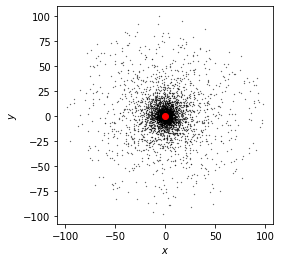

In [63]:
x, y, z = disc.arrays['position'][:, 0], disc.arrays['position'][:, 1], disc.arrays['position'][:, 2]

fig, ax = plt.subplots()
ax.plot(x[::10], y[::10], 'k.', ms=0.5)
for sink in setup.sinks:
    ax.plot(sink.position[0], sink.position[1], 'ro')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

Next we plot the particles in the rz-plane.

(-18.958930206823098, 16.058317596908037)

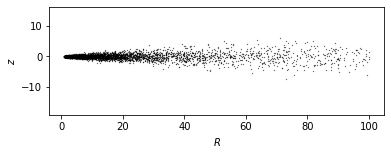

In [64]:
position_cylindrical, velocity_cylindrical = phantomsetup.geometry.coordinate_transform(
    position=disc.arrays['position'],
    velocity=disc.arrays['velocity'],
    geometry_from='cartesian',
    geometry_to='cylindrical'
)

R = position_cylindrical[:, 0]

fig, ax = plt.subplots()
ax.plot(R[::10], z[::10], 'k.', ms=0.5)
ax.set_xlabel('$R$')
ax.set_ylabel('$z$')
ax.set_aspect('equal')
ax.set_ylim(bottom=2 * z.min(), top=2 * z.max())

Finally, we plot $v_{\phi}$ as a function of radius.

Text(0, 0.5, '$v_{\\phi}$')

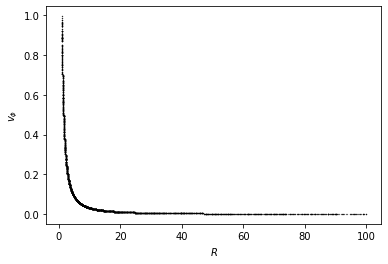

In [65]:
vphi = velocity_cylindrical[:, 1]

fig, ax = plt.subplots()
ax.plot(R[::10], vphi[::10], 'k.', ms=0.5)
ax.set_xlabel('$R$')
ax.set_ylabel('$v_{\phi}$')

## Write to file

Now that we are happy with the setup, write the "temporary" dump file with the initial conditions and the Phantom "in" file.

First we set a working directory for the simulation.

In [66]:
working_dir = '~/phantom-runs/disc5'

In [67]:
setup.write_dump_file(directory=working_dir)
setup.write_in_file(directory=working_dir)

PhantomSetup('disc')

## Viscosity options 

(Need to be here to ensure compilation happens with the right flag)

In [68]:

#all needs to be False to start with
setup.set_compile_option('DISC_VISCOSITY', False)

#set the required flag here
viscosity_flag='CONST_AV'

if viscosity_flag=='DISC_VISCOSITY':
    setup.set_compile_option('DISC_VISCOSITY', True)
elif viscosity_flag == 'CONST_AV':
    setup.set_compile_option('CONST_AV', True)
elif viscosity_flag == 'MORRIS_MONAGHAN':
    setup.set_compile_option("MORRIS_MONAGHAN", True)

## Compile Phantom

You can start a Phantom calculation from these two files but you must compile Phantom with the correct Makefile variables. We can use the `phantom_compile_command` method to show how Phantom would be compiled.

In [69]:
setup.set_compile_option("STORE_TEMPERATURE",True)
print(setup.phantom_compile_command(hdf5root='/opt/local/'))

make \
  SETUP=empty \
  SYSTEM=gfortran \
  HDF5=yes \
  HDF5ROOT=/opt/local/ \
  DISC_VISCOSITY=no \
  DRIVING=no \
  DUST=no \
  DUSTGROWTH=no \
  GRAVITY=yes \
  H2CHEM=no \
  IND_TIMESTEPS=yes \
  INJECT_PARTICLES=no \
  ISOTHERMAL=yes \
  KERNEL=cubic \
  MAXDUSTSMALL=11 \
  MAXDUSTLARGE=11 \
  MCFOST=no \
  MHD=no \
  NONIDEALMHD=no \
  PERIODIC=no \
  PHOTO=no \
  MORRIS_MONAGHAN=no \
  CONST_AV=yes \
  STORE_TEMPERATURE=yes


To compile Phantom we can use the `compile_phantom` method to compile Phantom. For example, the following will compile Phantom located in `phantom_dir` and copy the binary to `working_dir`.

In [70]:
result = setup.compile_phantom(
    phantom_dir='~/phantom-i/',
    working_dir=working_dir,
    hdf5root='/opt/local'
)

Compilation successful.
